# Low-overhead error detection with spacetime codes

*Usage estimate: 10 seconds on a Heron r3 processor (NOTE: This is an estimate only. Your runtime might vary.)*

## Introduction

[Low-overhead error detection with spacetime codes](https://arxiv.org/abs/2504.15725) [1] by Simon Martiel and Ali Javadi-Abhari proposes synthesizing low-weight, connectivity-aware spacetime checks for Clifford-dominated circuits, then postselecting on those checks to catch faults with far less overhead than full error correction and fewer shots than standard error mitigation.

This paper proposes a novel method for error detection in quantum circuits (specifically Clifford circuits) that strikes a balance between full error correction and lighter-weight mitigation techniques. The key idea is to use spacetime codes to generate "checks" across the circuit that are capable of catching errors, with significantly lower qubit and gate overhead than full fault‑tolerant error correction. The authors design efficient algorithms to select checks that are low-weight (involving few qubits), compatible with the physical connectivity of the device, and cover large temporal and spatial regions of the circuit. They demonstrate the approach on circuits with up to 50 logical qubits and ~2450 CZ gates, achieving physical-to-logical fidelity gains of up to 236x. Also note that as circuits include more non‑Clifford operations, the number of valid checks shrinks exponentially, indicating the method works best for Clifford‑dominated circuits. Overall, in the near term, error detection via spacetime codes may offer a practical, lower-overhead route to improving reliability in quantum hardware.

This error detection technique relies on the notion of coherent Pauli checks and is based on the work [Single-shot error mitigation by coherent Pauli checks](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.033193) [2] by van den Berg et al.

More recently, the paper [Big cats: entanglement in 120 qubits and beyond](https://arxiv.org/abs/2510.09520) [3] by Javadi-Abhari et al. reports the creation of a 120-qubit Greenberger–Horne–Zeilinger (GHZ) state, the largest multipartite entangled state achieved to date on a superconducting-qubit platform. Using a hardware-aware compiler, low-overhead error detection, and a "temporary uncomputation" technique to reduce noise, the researchers achieved a fidelity of 0.56 ± 0.03 with about 28% post-selection efficiency. The work demonstrates genuine entanglement across all 120 qubits, validating multiple fidelity-certification methods, and marks a major benchmark for scalable quantum hardware.

This tutorial builds on these ideas, guiding you through implementing the error detection algorithm first on a small-scale random Clifford circuit and then through the task of GHZ state preparation, to help you experiment with error detection on your own quantum circuits.

### Requirements
Before starting this tutorial, ensure that you have the following installed:

- Qiskit SDK v2.0 or later with visualization support (`pip install 'qiskit[visualization]'`)
- Qiskit IBM Runtime v0.40 or later (`pip install qiskit-ibm-runtime`)
- Qiskit Aer v0.17.2 (`pip install qiskit-aer`)
- [Qiskit Device Benchmarking](https://github.com/qiskit-community/qiskit-device-benchmarking) (`pip install "qiskit-device-benchmarking @ git+https://github.com/qiskit-community/qiskit-device-benchmarking.git"`)
- NumPy v2.3.2 (`pip install numpy`)
- Matplotlib v3.10.7 (`pip install matplotlib`)

### Setup

In [ ]:
# Standard library imports
from collections import defaultdict, deque
from functools import partial

# External libraries
import matplotlib.pyplot as plt
import numpy as np

# Qiskit
from qiskit import ClassicalRegister, QuantumCircuit
from qiskit.circuit import Delay
from qiskit.circuit.library import RZGate, XGate
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import Pauli, random_clifford
from qiskit.transpiler import AnalysisPass, PassManager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    CollectAndCollapse,
    PadDelay,
    PadDynamicalDecoupling,
    RemoveBarriers,
)
from qiskit.transpiler.passes.optimization.collect_and_collapse import (
    collect_using_filter_function,
    collapse_to_operation,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

# Qiskit Aer
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, ReadoutError, depolarizing_error

# Qiskit IBM Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Qiskit Device Benchmarking
from qiskit_device_benchmarking.utilities.gate_map import plot_gate_map

## First example

To demonstrate this method, we start by constructing a simple Clifford circuit. Our goal is to be able to detect when certain types of error occur in this circuit, so that we can discard erroneous measurement results. In error detection terminology, this is also known as our payload circuit.

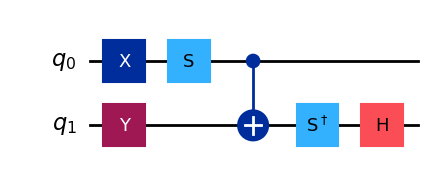

In [ ]:
circ = random_clifford(num_qubits=2, seed=11).to_circuit()
circ.draw("mpl")

Our goal is to insert a coherent Pauli check into this payload circuit. But before we do that, we separate this circuit into layers. This will be useful later when inserting Pauli gates in between.

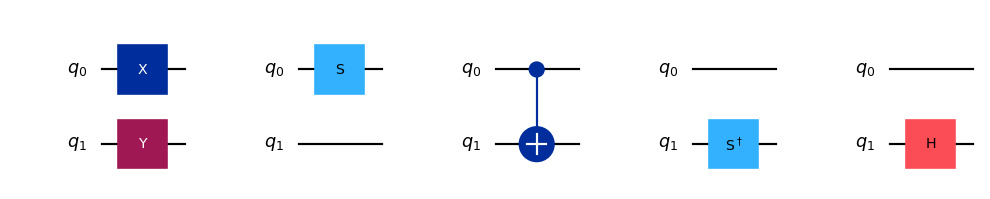

In [3]:
# Separate circuit into layers
dag = circuit_to_dag(circ)
circ_layers = []
for layer in dag.layers():
    layer_as_circuit = dag_to_circuit(layer["graph"])
    circ_layers.append(layer_as_circuit)

# Create subplots
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(10, 4))

# Draw circuits on respective axes
circ_layers[0].draw(output="mpl", ax=ax1)
circ_layers[1].draw(output="mpl", ax=ax2)
circ_layers[2].draw(output="mpl", ax=ax3)
circ_layers[3].draw(output="mpl", ax=ax4)
circ_layers[4].draw(output="mpl", ax=ax5)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Now we are ready to add coherent Pauli checks into the payload circuit. To do this, we need to construct a "valid check" and insert it into the circuit. A "check" in this case is an operator that is capable of signaling whether an error occurred in the circuit by making a measurement on an ancilla qubit. It is considered a valid check when the additional operators inserted into the quantum circuit don't logically change the original circuit.

This check is capable of detecting types of errors that anticommute with it, and the check will trigger a measurement of $\ket{1}$ state in the ancilla qubit instead of $\ket{0}$ through phase kickback. Therefore, we will be able to discard measurements where an error was signaled.

In general, coherent Pauli checks are controlled-Pauli operators inserted into "wires" - spacetime locations between gates. The ancilla qubit responsible for signaling the error is the control qubit.

Below we construct a valid check for the Clifford circuit we created above. We can demonstate that this check doesn't change the circuit operation by showing that when these Pauli checks are propagated to the front of the circuit, they cancel each other out. This is easily shown because a Pauli operator through a Clifford gate is another Pauli operator.

In general, one can use a decoding heuristic as outlined in [[1]](https://arxiv.org/abs/2504.15725) to identify valid checks. For the purposes of our initial example, we can also construct valid checks by using analytical Pauli and Clifford gate multiplication conditions.

In [4]:
# Define a valid check
pauli_1 = Pauli("ZI")
pauli_2 = Pauli("XZ")

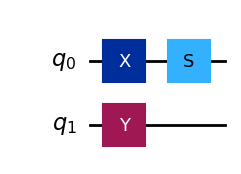

In [5]:
circ_1 = circ_layers[0].compose(circ_layers[1])
circ_1.draw("mpl")

In [6]:
pauli_1_ev = pauli_1.evolve(circ_1, frame="h")
pauli_1_ev

Pauli('-ZI')

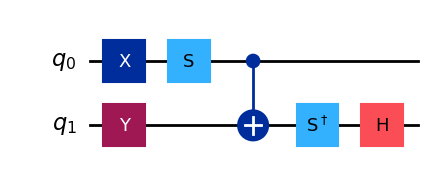

In [7]:
circ_2 = circ.copy()
circ_2.draw("mpl")

In [8]:
pauli_2_ev = pauli_2.evolve(circ_2, frame="h")
pauli_2_ev

Pauli('-ZI')

In [9]:
pauli_1_ev.dot(pauli_2_ev)

Pauli('II')

As we can see, we have a valid check, since the inserted Pauli operators simply have the same effect as an identity operator on the circuit. We can now insert these checks into the circuit with an ancilla qubit. This ancilla qubit, or the check qubit, starts the in the $\ket{+}$ state. It includes the controlled versions of the Pauli operations outlined above and is finally measured in the $X$ basis. This check qubit is now capable of capturing errors in the payload circuit without logically altering it. This is because certain types of noise in the payload circuit will modify the state of the check qubit, and it will be measured "1" instead of "0" in case such an error occurs.

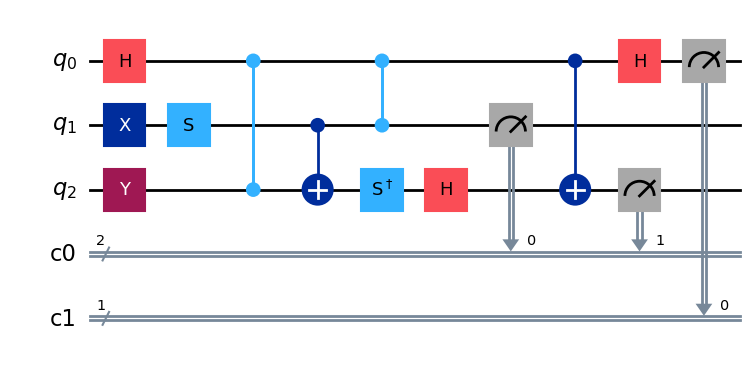

In [10]:
# New circuit with 3 qubits (2 payload + 1 ancilla for check)
circ_meas = QuantumCircuit(3)
circ_meas.h(0)
circ_meas.compose(circ_layers[0], [1, 2], inplace=True)
circ_meas.compose(circ_layers[1], [1, 2], inplace=True)
circ_meas.cz(0, 2)
circ_meas.compose(circ_layers[2], [1, 2], inplace=True)
circ_meas.compose(circ_layers[3], [1, 2], inplace=True)
circ_meas.compose(circ_layers[4], [1, 2], inplace=True)
circ_meas.cz(0, 1)
circ_meas.cx(0, 2)
circ_meas.h(0)

# Add measurement to payload qubits
c0 = ClassicalRegister(2, name="c0")
circ_meas.add_register(c0)
circ_meas.measure(1, c0[0])
circ_meas.measure(2, c0[1])

# Add measurement to check qubit
c1 = ClassicalRegister(1, name="c1")
circ_meas.add_register(c1)
circ_meas.measure(0, c1[0])

# Visualize the final circuit with the inserted checks
circ_meas.draw("mpl")

If the check qubit is measured in "0", we keep that measurement. If it's measured in "1", then this means that that an error occurred in the payload circuit, and we discard that measurement.

In [11]:
# Noiseless simulation using stabilizer method
sim_stab = AerSimulator(method="stabilizer")
res = sim_stab.run(circ_meas, shots=1000).result()
counts_noiseless = res.get_counts()
print(f"Stabilizer simulation result: {counts_noiseless}")

Stabilizer simulation result: {'0 11': 523, '0 01': 477}


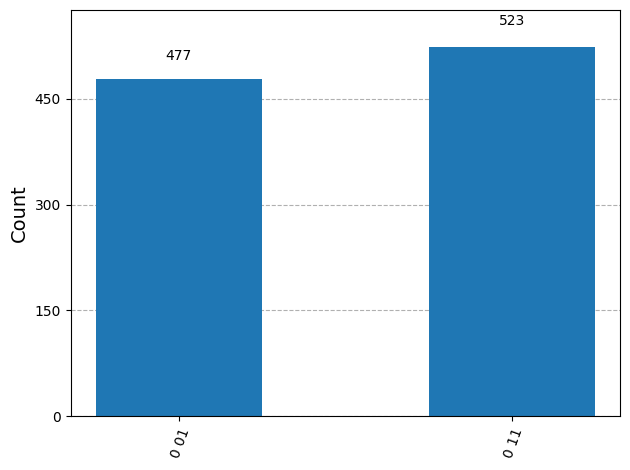

In [12]:
# Plot the noiseless results
# Note that the first bit in the key corresponds to the check qubit
plot_histogram(counts_noiseless)

Note that with an ideal simulator, the check qubit doesn't detect any errors. We now introduce a noise model to the simulation and see how the check qubit captures errors.

In [ ]:
# Qiskit Aer noise model
noise = NoiseModel()
p2 = 0.003  # two-qubit depolarizing per CZ
p1 = 0.001  # one-qubit depolarizing per 1q Clifford
pr = 0.01  # readout bit-flip probability

# 1q depolarizing on common 1q gates
e1 = depolarizing_error(p1, 1)
for g1 in ["id", "rz", "sx", "x", "h", "s"]:
    noise.add_all_qubit_quantum_error(e1, g1)

# 2q depolarizing on CZ
e2 = depolarizing_error(p2, 2)
noise.add_all_qubit_quantum_error(e2, "cz")

# Readout error on measure
ro = ReadoutError([[1 - pr, pr], [pr, 1 - pr]])
noise.add_all_qubit_readout_error(ro)

# Qiskit Aer simulation with noise model
aer = AerSimulator(method="automatic", seed_simulator=43210)
job = aer.run(circ_meas, shots=1000, noise_model=noise)
result = job.result()
counts_noisy = result.get_counts()
print(f"Noise model simulation result: {counts_noisy}")

Noise model simulation result: {'1 01': 5, '0 11': 478, '1 11': 6, '1 00': 2, '1 10': 1, '0 01': 500, '0 00': 5, '0 10': 3}


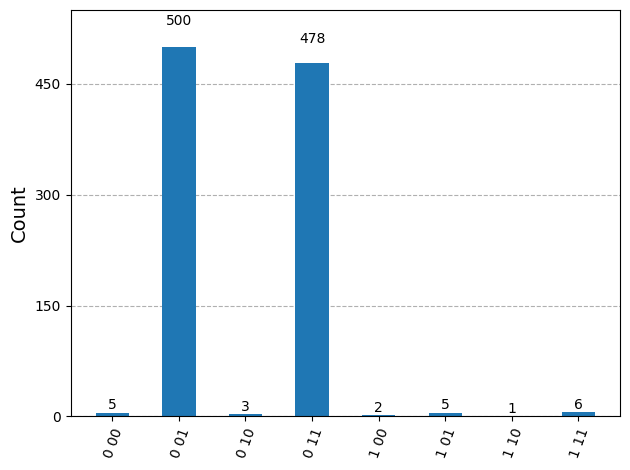

In [14]:
plot_histogram(counts_noisy)

As we can see, some measurements captured the error by flagging the check qubit as "1", which are visible in the last four columns. These shots are discarded.

Note: The ancilla qubit can also introduce new errors to the circuit. To reduce the effect of this, we can insert nested checks with additional ancilla qubits to the quantum circuit.

## Real-world example: Prepare a GHZ state on real hardware

## Step 1: Map to a quantum problem

Now we demonstate a significant task for quantum computing algorithms, which is preparing a GHZ state. We will demonstrate how to do this on a real backend using error detection.

In [ ]:
# Set optional seed for reproducibility
SEED = 1

if SEED:
    np.random.seed(SEED)

The error detection algorithm for GHZ state preparation respects the hardware topology. We begin by selecting the desired hardware.

In [ ]:
# This is used to run on real hardware
service = QiskitRuntimeService()

# Choose a backend to build GHZ on
backend_name = service.least_busy(
    operational=True, simulator=False, min_num_qubits=133
)
token = "<YOUR_TOKEN>"

# This is used to retrieve shared results
shared_service = QiskitRuntimeService(
    channel="ibm_quantum_platform",
    token=token,
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/e2e570bc5af249dc9d81711cc2febac7:4a48cdfe-2d4f-4ea2-b5c6-874995623813::",
)

backend = service.backend(backend_name)
coupling_map = backend.target.build_coupling_map()

qiskit_runtime_service._discover_account:WARNING:2025-11-10 22:44:05,069: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service._discover_account:WARNING:2025-11-10 22:44:07,929: Loading account with the given token. A saved account will not be used.


A GHZ state on $n$ qubits is defined as
$$\lvert \mathrm{GHZ}_n\rangle \;=\; \frac{1}{\sqrt{2}}\Big(\lvert 0\rangle^{\otimes n} \,+\, \lvert 1\rangle^{\otimes n}\Big).$$

A very naive approach to prepare the GHZ state would be to choose a root qubit with an initial Hadamard gate, which puts the qubit to an equal superposition state, and then to entangle this qubit with every other qubit. This is not a good approach, since it requires long-range and deep CNOT interactions. In this tutorial, we will utilize multiple techniques alongside error detection to reliably prepare the GHZ state on real hardware.

## Step 2: Optimize problem for quantum hardware execution

### Map the GHZ state to hardware

First, we search for a root to map the GHZ circuit on hardware. We remove edges/nodes whose CZ errors, measurement errors, and the T2 values are worse than the thresholds below. These will not be included in the GHZ circuit.

In [17]:
def bad_cz(target, threshold=0.01):
    """Return list of edges whose CZ error is worse than threshold."""
    undirected_edges = []
    for edge in backend.target.build_coupling_map().get_edges():
        if (edge[1], edge[0]) not in undirected_edges:
            undirected_edges.append(edge)
    edges = undirected_edges
    cz_errors = {}
    for edge in edges:
        cz_errors[edge] = target["cz"][edge].error
    worst_edges = sorted(cz_errors.items(), key=lambda x: x[1], reverse=True)
    return [list(edge) for edge, error in worst_edges if error > threshold]


def bad_readout(target, threshold=0.01):
    """Return list of nodes whose measurement error is worse than threshold."""
    meas_errors = {}
    for node in range(backend.num_qubits):
        meas_errors[node] = target["measure"][(node,)].error
    worst_nodes = sorted(
        meas_errors.items(), key=lambda x: x[1], reverse=True
    )
    return [node for node, error in worst_nodes if error > threshold]


def bad_coherence(target, threshold=60):
    """Return list of nodes whose T2 value is lower than threshold."""
    t2s = {}
    for node in range(backend.num_qubits):
        t2 = target.qubit_properties[node].t2
        t2s[node] = t2 * 1e6 if t2 else 0
    worst_nodes = sorted(t2s.items(), key=lambda x: x[1])
    return [node for node, val in worst_nodes if val < threshold]


THRESH_CZ = 0.025  # exclude from BFS those edges whose CZ error is worse than this threshold
THRESH_MEAS = 0.15  # exclude from BFS those nodes whose measurement error is worse than this threshold
THRESH_T2 = 10  # exclude from BFS those nodes whose T2 value is lower than this threshold

bad_edges = bad_cz(backend.target, threshold=THRESH_CZ)
bad_nodes_readout = bad_readout(backend.target, threshold=THRESH_MEAS)
dead_qubits = bad_readout(backend.target, threshold=0.4)
bad_nodes_coherence = bad_coherence(backend.target, threshold=THRESH_T2)
bad_nodes = list(set(bad_nodes_readout) | set(bad_nodes_coherence))
print(f"{len(bad_edges)} bad edges: \n{bad_edges}")
print(f"{len(bad_nodes)} bad nodes: \n{bad_nodes}")

17 bad edges: 
[[30, 31], [112, 113], [113, 114], [113, 119], [120, 121], [130, 131], [145, 146], [146, 147], [111, 112], [55, 59], [64, 65], [131, 138], [131, 132], [119, 133], [129, 130], [47, 57], [29, 38]]
5 bad nodes: 
[1, 113, 131, 146, 120]


Using the function below, we construct the GHZ circuit on the chosen hardware starting from the root and using breadth-first search (BFS).

In [18]:
def parallel_ghz(root, num_qubits, backend, bad_edges, skip):
    """
    Build a GHZ state of size `num_qubits` on the given `backend`,
    starting from `root`, expanding in BFS order.

    At each BFS layer, every active qubit adds at most one new neighbor
    (so that two-qubit operations can run in parallel with no qubit conflicts).

    It grows the entanglement tree outward layer-by-layer.
    """

    # -------------------------------------------------------------
    # (1) Filter usable connections from the backend coupling map
    # -------------------------------------------------------------
    # The coupling map lists all directed hardware connections as (control, target).
    # We remove edges that are:
    #   - listed in `bad_edges` (or their reversed form)
    #   - involve a qubit in the `skip` list
    cmap = backend.configuration().coupling_map
    edges = [
        e
        for e in cmap
        if e not in bad_edges
        and [e[1], e[0]] not in bad_edges
        and e[0] not in skip
        and e[1] not in skip
    ]

    # -------------------------------------------------------------
    # (2) Build an undirected adjacency list for traversal
    # -------------------------------------------------------------
    # Even though coupling_map edges are directed, BFS expansion just needs
    # connectivity information (so we treat edges as undirected for search).
    adj = defaultdict(list)
    for u, v in edges:
        adj[u].append(v)
        adj[v].append(u)

    # -------------------------------------------------------------
    # (3) Initialize the quantum circuit and BFS state
    # -------------------------------------------------------------
    n = backend.configuration().num_qubits
    qc = QuantumCircuit(
        n
    )  # create a circuit with same number of qubits as hardware
    visited = [
        root
    ]  # record the order qubits are added to the GHZ chain/tree
    queue = deque([root])  # BFS queue (start from root)
    explored = defaultdict(
        set
    )  # to track which neighbors each node has already explored
    layers = []  # list of per-layer (control, target) gate tuples
    qc.h(root)  # GHZ states start with a Hadamard on the root qubit

    # -------------------------------------------------------------
    # (4) BFS expansion: build the GHZ tree one layer at a time
    # -------------------------------------------------------------
    # Loop until we’ve added the desired number of qubits to the GHZ
    while queue and len(visited) < num_qubits:
        layer = []  # collect new (control, target) pairs for this layer
        current = list(
            queue
        )  # snapshot current frontier (so queue mutations don’t affect iteration)
        busy = (
            set()
        )  # track qubits already used in this layer (to avoid conflicts)

        for node in current:
            queue.popleft()

            # find one unvisited neighbor of this node not already explored
            unvisited_neighbors = [
                nb
                for nb in adj[node]
                if nb not in visited and nb not in explored[node]
            ]

            if unvisited_neighbors:
                nb = unvisited_neighbors[
                    0
                ]  # pick the first available neighbor
                visited.append(nb)  # mark it as part of the GHZ structure
                queue.append(
                    node
                )  # re-enqueue current node (can keep growing)
                queue.append(nb)  # enqueue the newly added qubit
                explored[node].add(nb)  # mark that edge as explored
                layer.append(
                    (node, nb)
                )  # schedule a CNOT between node and neighbor
                busy.update([node, nb])  # reserve both qubits for this layer

                # stop early if we've reached the desired number of qubits
                if len(visited) == num_qubits:
                    break
            # else: node has no unused unvisited neighbors left → skip

        if layer:
            # add all pairs (node, nb) scheduled this round to layers
            layers.append(layer)
        else:
            # nothing new discovered this pass → done
            break

    # -------------------------------------------------------------
    # (5) Emit all layers into the quantum circuit
    # -------------------------------------------------------------
    # For each layer:
    #   - apply a CX gate for every (control, target) pair
    #   - insert a barrier so transpiler keeps layer structure
    for layer in layers:
        for q1, q2 in layer:
            qc.cx(q1, q2)
        qc.barrier()

    # -------------------------------------------------------------
    # (6) Return outputs
    # -------------------------------------------------------------
    # qc: the built quantum circuit
    # visited: order of qubits added
    # layers: list of parallelizable two-qubit operations per step
    return qc, visited, layers

We now repeatedly search for the best root, where the GHZ circuit will originate from.

In [19]:
ROOT = None  # root for BFS search
GHZ_SIZE = 100  # number of (data) qubits in the GHZ state
SKIP = []  # nodes to intentionally skip so that we have a better chance for finding checks

# Search for the best root (yieling the shallowest GHZ)
if ROOT is None:
    best_root = -1
    base_depth = 100
    for root in range(backend.num_qubits):
        qc, ghz_qubits, _ = parallel_ghz(
            root, GHZ_SIZE, backend, bad_edges, SKIP
        )
        if len(ghz_qubits) != GHZ_SIZE:
            continue
        depth = qc.depth(lambda x: x.operation.num_qubits == 2)
        if depth < base_depth:
            best_root = root
            base_depth = depth
    ROOT = best_root

We now construct the GHZ circuit starting from a specific node - as in, the best root - searching for the shortest depth using breadth-first search.

In [20]:
# Build a GHZ starting at the best root
qc, ghz_qubits, _ = parallel_ghz(
    ROOT, GHZ_SIZE, backend, bad_edges, SKIP + bad_nodes
)
base_depth = qc.depth(lambda x: x.operation.num_qubits == 2)
base_count = qc.size(lambda x: x.operation.num_qubits == 2)
print(f"base depth: {base_depth}, base count: {base_count}")
print(f"ROOT: {ROOT}")
if len(ghz_qubits) != GHZ_SIZE:
    raise Exception("No GHZ found. Relax error thresholds.")

base depth: 17, base count: 99
ROOT: 50


We need one final consideration before inserting valid checks. This is related to the concept of "coverage", which is a measure of how many of the wires in a quantum circuit a check can cover. With a higher coverage, we can detect errors on a wider part of the circuit. With this measure, we can select among the valid checks with the highest circuit coverage. In other words, we will be using the `weighted_coverage` function to score different checks for the GHZ circuit.

In [ ]:
def weighted_coverage(layers, parities, w_idle=0.2, w_gate=0.8):
    """
    Compute weighted fraction (idle + gate) of wires that are
    covered by at least one parity to all active wires.
    """
    wires = active_wires(layers)  # defined below
    covered_by_any = {l: set() for l in range(len(layers))}
    for parity in parities:
        trace = z_trace_backward(layers, parity)  # defined below
        for l, qs in trace.items():
            covered_by_any[l] |= qs
    covered_weight = 0
    total_weight = 0
    for l in range(len(layers)):
        idle = wires[l]["idle"]
        gate = wires[l]["gate"]
        total_weight += w_idle * len(idle) + w_gate * len(gate)
        covered_idle = covered_by_any[l] & idle
        covered_gate = covered_by_any[l] & gate
        covered_weight += w_idle * len(covered_idle) + w_gate * len(
            covered_gate
        )
    return covered_weight / total_weight if total_weight > 0 else 0


def active_wires(layers):
    """
    Returns per-layer dict with two sets:
    - 'idle': activated wires that are idle in this layer
    - 'gate': activated wires that are control/target of a CNOT at this layer
    """
    first_activation = {}
    for l, layer in enumerate(layers):
        for c, t in layer:
            first_activation.setdefault(c, l)
            first_activation.setdefault(t, l)
    result = {}
    for l in range(len(layers)):
        active = {q for q, l0 in first_activation.items() if l >= l0}
        gate = {q for c, t in layers[l] for q in (c, t)}
        idle = active - gate
        result[l] = {"idle": idle, "gate": gate}
    return result


def z_trace_backward(layers, initial_Zs):
    """
    Backward propagate Zs with parity cancellation.
    Returns {layer: set of qubits with odd parity Z at that layer}.
    """
    wires = active_wires(layers)
    support = set(initial_Zs)
    trace = {}
    for l in range(len(layers) - 1, -1, -1):
        active = wires[l]["idle"] | wires[l]["gate"]
        trace[l] = support & active
        # propagate backwards
        new_support = set()
        for q in support:
            hit = False
            for c, t in layers[l]:
                if q == t:  # Z on target: copy to control
                    new_support ^= {t, c}  # toggle both
                    hit = True
                    break
                elif q == c:  # Z on control: passes through
                    new_support ^= {c}
                    hit = True
                    break
            if not hit:  # unaffected
                new_support ^= {q}
        support = new_support
    return trace

We can now insert checks to the GHZ circuit. Finding valid checks is very convenient for the GHZ state, since any two-qubit Pauli $Z$ operator $Z_i Z_j$ acting on any two qubits $i,j$ of the GHZ circuit is a support and therefore a valid check.

Also note that the checks in this case are controlled-$Z$ operators neigboring Hadamard gates from the left and right on the ancilla qubit. This is equivalent to a CNOT gate applied to the ancilla qubit. The code below inserts the checks into the circuit.

In [ ]:
# --- Tunables controlling the search space / scoring ---
MAX_SKIPS = 10  # at most how many qubits to skip (in addition to the bad ones and the ones forced to skip above)
SHUFFLES = 200  # how many times to try removing nodes for checks
MAX_DEPTH_INCREASE = 10  # how far from the base GHZ depth to go to include checks (increase this for more checks at expense of depth)

W_IDLE = 0.2  # weight of errors to consider during idle timesteps
W_GATE = 0.8  # weight of errors to consider during gates

# Remove random nodes from the GHZ and build from the root again to increase checks
degree_two_nodes = [
    i
    for i in ghz_qubits
    if all(n in ghz_qubits for n in coupling_map.neighbors(i))
    and len(coupling_map.neighbors(i)) >= 2
]

# --- Best-so-far tracking for the randomized search ---
num_checks = 0
best_covered_fraction = -1
best_qc = qc
best_checks = []
best_parities = []
best_layers = []

# Outer loop: vary how many GHZ nodes we try skipping (0..MAX_SKIPS-1)
for num_skips in range(MAX_SKIPS):
    # Inner loop: try SHUFFLES random choices of 'num_skips' nodes to skip
    for _ in range(SHUFFLES):
        # Construct the skip set:
        #   - pre-existing forced SKIP
        #   - plus a random sample of 'degree_two_nodes' of size 'num_skips'
        skip = SKIP + list(np.random.choice(degree_two_nodes, num_skips))

        # Rebuild the GHZ using the current skip set and bad_nodes
        qc, ghz_qubits, layers = parallel_ghz(
            ROOT, GHZ_SIZE, backend, bad_edges, skip + bad_nodes
        )

        # Measure circuit cost as 2-qubit-gate depth only
        depth = qc.depth(lambda x: x.operation.num_qubits == 2)

        # If we failed to reach the target GHZ size, discard this attempt
        if len(ghz_qubits) != GHZ_SIZE:
            continue

        # --- Build "checks" around the GHZ we just constructed ---
        # A check qubit is a non-GHZ, non-dead qubit that has ≥2 neighbors inside the GHZ
        # and all those incident edges are usable (i.e., not in bad_edges).
        checks = []
        parities = []
        for i in range(backend.num_qubits):
            neighbors = [
                n for n in coupling_map.neighbors(i) if n in ghz_qubits
            ]

            if (
                i not in ghz_qubits
                and i not in dead_qubits
                and len(neighbors) >= 2
                and not any(
                    [
                        [neighbor, i] in bad_edges
                        or [i, neighbor] in bad_edges
                        for neighbor in neighbors
                    ]
                )
            ):
                # Record this qubit as a check qubit
                checks.append(i)
                parities.append((neighbors[0], neighbors[1]))
                # Physically couple the check qubit 'i' to the two GHZ neighbors via CNOTs
                # (This is the actual "check" attachment in the circuit.)
                qc.cx(neighbors[0], i)
                qc.cx(neighbors[1], i)

        # Score this design using the weighted coverage metric over the GHZ build layers
        covered_fraction = weighted_coverage(
            layers=layers, parities=parities, w_idle=W_IDLE, w_gate=W_GATE
        )

        # Keep it only if:
        #   - coverage improves over the best so far, AND
        #   - the 2q depth budget isn't blown by more than MAX_DEPTH_INCREASE
        if (
            covered_fraction > best_covered_fraction
            and depth <= base_depth + MAX_DEPTH_INCREASE
        ):
            best_covered_fraction = covered_fraction
            best_qc = qc
            best_ghz_qubits = ghz_qubits
            best_checks = checks
            best_parities = parities
            best_layers = layers

We can now print out the qubits used in the GHZ circuit and the check qubits.

In [23]:
# --- After search, report the best design found ---
qc = best_qc
checks = best_checks
parities = best_parities
layers = best_layers
ghz_qubits = best_ghz_qubits
if len(ghz_qubits) != GHZ_SIZE:
    raise Exception("No GHZ found. Relax error thresholds.")

print(f"GHZ qubits: {ghz_qubits} {len(ghz_qubits)}")
print(f"Check qubits: {checks} {len(checks)}")

covered_fraction = weighted_coverage(
    layers=layers, parities=parities, w_idle=W_IDLE, w_gate=W_GATE
)
print(
    "Covered fraction (no idle): ",
    weighted_coverage(
        layers=layers, parities=parities, w_idle=0.0, w_gate=1.0
    ),
)

GHZ qubits: [50, 49, 51, 38, 52, 48, 58, 53, 47, 71, 39, 46, 70, 54, 33, 45, 72, 69, 55, 32, 37, 73, 68, 34, 31, 44, 25, 74, 78, 67, 18, 24, 79, 75, 89, 57, 11, 23, 93, 59, 88, 66, 10, 22, 92, 90, 87, 65, 12, 9, 21, 94, 91, 86, 77, 13, 8, 20, 95, 98, 97, 14, 7, 36, 99, 111, 107, 15, 6, 41, 115, 110, 106, 19, 17, 5, 40, 114, 109, 108, 105, 27, 4, 42, 118, 104, 28, 3, 129, 117, 103, 29, 2, 128, 125, 96, 30, 127, 124, 102] 100
Check qubits: [16, 26, 35, 43, 85, 126] 6
Covered fraction (no idle):  0.4595959595959596


We can also print out some error statistics.

In [24]:
def circuit_errors(target, circ, error_type="cz"):
    """
    Pull per-resource error numbers from a Qiskit Target
    for ONLY the qubits/edges actually used by `circ`.

    Args:
        target: qiskit.transpiler.Target (e.g., backend.target)
        circ:   qiskit.QuantumCircuit
        error_type: one of {"cz", "meas", "t1", "t2"}:
            - "cz"   -> 2q CZ gate error on the circuit's used edges
            - "meas" -> measurement error on the circuit's used qubits
            - "t1"   -> T1 (converted to microseconds) on used qubits
            - "t2"   -> T2 (converted to microseconds) on used qubits

    Returns:
        list[float] of the requested quantity for the active edges/qubits.
    """

    # Get all 2-qubit edges that appear in the circuit (as undirected pairs).
    active_edges = active_gates(circ)  # e.g., {(0,1), (2,3), ...}

    # Intersect those with the device coupling map (so we only query valid edges).
    # Note: target.build_coupling_map().get_edges() yields directed pairs.
    edges = [
        edge
        for edge in target.build_coupling_map().get_edges()
        if tuple(sorted(edge)) in active_edges
    ]

    # Deduplicate direction: keep only one orientation of each edge.
    undirected_edges = []
    for edge in edges:
        if (edge[1], edge[0]) not in undirected_edges:
            undirected_edges.append(edge)
    edges = undirected_edges  # (not used later—see note below)

    # Accumulators for different error/physics quantities
    cz_errors, meas_errors, t1_errors, t2_errors = [], [], [], []

    # For every active (undirected) edge in the circuit, fetch its CZ error.
    # NOTE: Uses active_gates(circ) again (undirected tuples). This assumes
    # `target['cz']` accepts undirected indexing; many Targets store both directions.
    for edge in active_gates(circ):
        cz_errors.append(target["cz"][edge].error)

    # For every active qubit, fetch measure error and T1/T2 (converted to µs).
    for qubit in active_qubits(circ):
        meas_errors.append(target["measure"][(qubit,)].error)
        t1_errors.append(
            target.qubit_properties[qubit].t1 * 1e6
        )  # seconds -> microseconds
        t2_errors.append(
            target.qubit_properties[qubit].t2 * 1e6
        )  # seconds -> microseconds

    # Select which set to return.
    if error_type == "cz":
        return cz_errors
    elif error_type == "meas":
        return meas_errors
    elif error_type == "t1":
        return t1_errors
    else:
        return t2_errors


def active_qubits(circ):
    """
    Return a list of qubit indices that participate in at least one
    non-delay, non-barrier instruction in `circ`.
    """
    active_qubits = set()
    for inst in circ.data:
        # Skip scheduling artifacts that don’t act on state
        if (
            inst.operation.name != "delay"
            and inst.operation.name != "barrier"
        ):
            for qubit in inst.qubits:
                q = circ.find_bit(
                    qubit
                ).index  # map Qubit object -> integer index
                active_qubits.add(q)
    return list(active_qubits)


def active_gates(circ):
    """
    Return a set of undirected 2-qubit edges (i, j) that appear in `circ`.
    """
    used_2q_gates = set()
    for inst in circ:
        if inst.operation.num_qubits == 2:
            qs = inst.qubits
            # map Qubit objects -> indices, then sort to make the edge undirected
            qs = sorted([circ.find_bit(q).index for q in qs])
            used_2q_gates.add(tuple(sorted(qs)))
    return used_2q_gates


# ---- Print summary statistics ----
cz_errors = circuit_errors(backend.target, qc, error_type="cz")
meas_errors = circuit_errors(backend.target, qc, error_type="meas")
t1_errors = circuit_errors(backend.target, qc, error_type="t1")
t2_errors = circuit_errors(backend.target, qc, error_type="t2")

np.set_printoptions(linewidth=np.inf)
print(
    f"cz errors: \n mean: {np.round(np.mean(cz_errors), 3)}, max: {np.round(np.max(cz_errors), 3)}"
)
print(
    f"meas errors: \n mean: {np.round(np.mean(meas_errors), 3)}, max: {np.round(np.max(meas_errors), 3)}"
)
print(
    f"t1 errors: \n mean: {np.round(np.mean(t1_errors), 1)}, min: {np.round(np.min(t1_errors), 1)}"
)
print(
    f"t2 errors: \n mean: {np.round(np.mean(t2_errors), 1)}, min: {np.round(np.min(t2_errors), 1)}"
)

cz errors: 
 mean: 0.002, max: 0.012
meas errors: 
 mean: 0.014, max: 0.121
t1 errors: 
 mean: 267.9, min: 23.6
t2 errors: 
 mean: 155.9, min: 13.9


As previously, we can simulate the circuit first in the absence of noise to ensure correctness of the GHZ state preparation circuit.

Stabilizer simulation result:
{'000000 1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111': 525, '000000 0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000': 475}


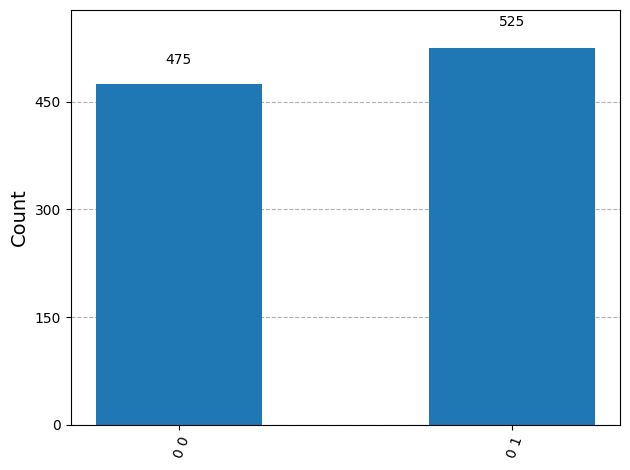

In [ ]:
# --- Simulate to ensure correctness ---

qc_meas = qc.copy()

# Add measurements to the GHZ qubits
c1 = ClassicalRegister(len(ghz_qubits), "c1")
qc_meas.add_register(c1)
for q, c in zip(ghz_qubits, c1):
    qc_meas.measure(q, c)

# Add measurements to the check qubits
if len(checks) > 0:
    c2 = ClassicalRegister(len(checks), "c2")
    qc_meas.add_register(c2)
    for q, c in zip(checks, c2):
        qc_meas.measure(q, c)

# Simulate the circuit with stabilizer method
sim_stab = AerSimulator(method="stabilizer")
res = sim_stab.run(qc_meas, shots=1000).result()
counts = res.get_counts()
print("Stabilizer simulation result:")
print(counts)

# Rename keys to "0 0" and "0 1" for easier plotting
# First len(checks) bits are check bits, rest are GHZ bits
keys = list(counts.keys())
for key in keys:
    check_bits = key[: len(checks)]
    ghz_bits = key[(len(checks) + 1) :]
    if set(check_bits) == {"0"} and set(ghz_bits) == {"0"}:
        counts["0 0"] = counts.pop(key)
    elif set(check_bits) == {"0"} and set(ghz_bits) == {"1"}:
        counts["0 1"] = counts.pop(key)
    else:
        continue

plot_histogram(counts)

As expected, the check qubits are measured as all zeros, and we successfully prepared the GHZ state.

## Step 3: Execute using Qiskit primitives

Now we are ready to run the circuit on real hardware and demonstrate how the error detection protocol can capture errors in GHZ state preparation.

In [ ]:
BAD_QUBITS = []  # specify any additional bad qubits to avoid (this is specific to the chosen backend)
SHOTS = 10000  # number of shots

We define a helper function to add measurements to the GHZ circuit.

In [ ]:
def add_measurements(qc, ghz_qubits, checks):
    # --- Measure each set of qubits into different classical registers to facilitate post-processing ---

    # Add measurements to the GHZ qubits
    c1 = ClassicalRegister(len(ghz_qubits), "c1")
    qc.add_register(c1)
    for q, c in zip(ghz_qubits, c1):
        qc.measure(q, c)

    # Add measurements to the check qubits
    c2 = ClassicalRegister(len(checks), "c2")
    qc.add_register(c2)
    for q, c in zip(checks, c2):
        qc.measure(q, c)

    return qc

Before execution, we draw the layout of the GHZ qubits and the check qubits on the selected hardware.

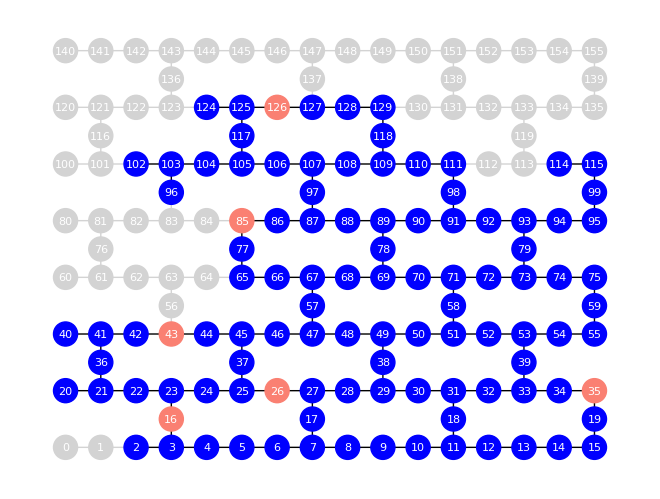

In [ ]:
# Plot the layout of GHZ and check qubits on the device
plot_gate_map(
    backend,
    label_qubits=True,
    line_width=20,
    line_color=[
        "black"
        if edge[0] in ghz_qubits + checks and edge[1] in ghz_qubits + checks
        else "lightgrey"
        for edge in backend.coupling_map.graph.edge_list()
    ],
    qubit_color=[
        "blue"
        if i in ghz_qubits
        else "salmon"
        if i in checks
        else "lightgrey"
        for i in range(0, backend.num_qubits)
    ],
)
plt.show()

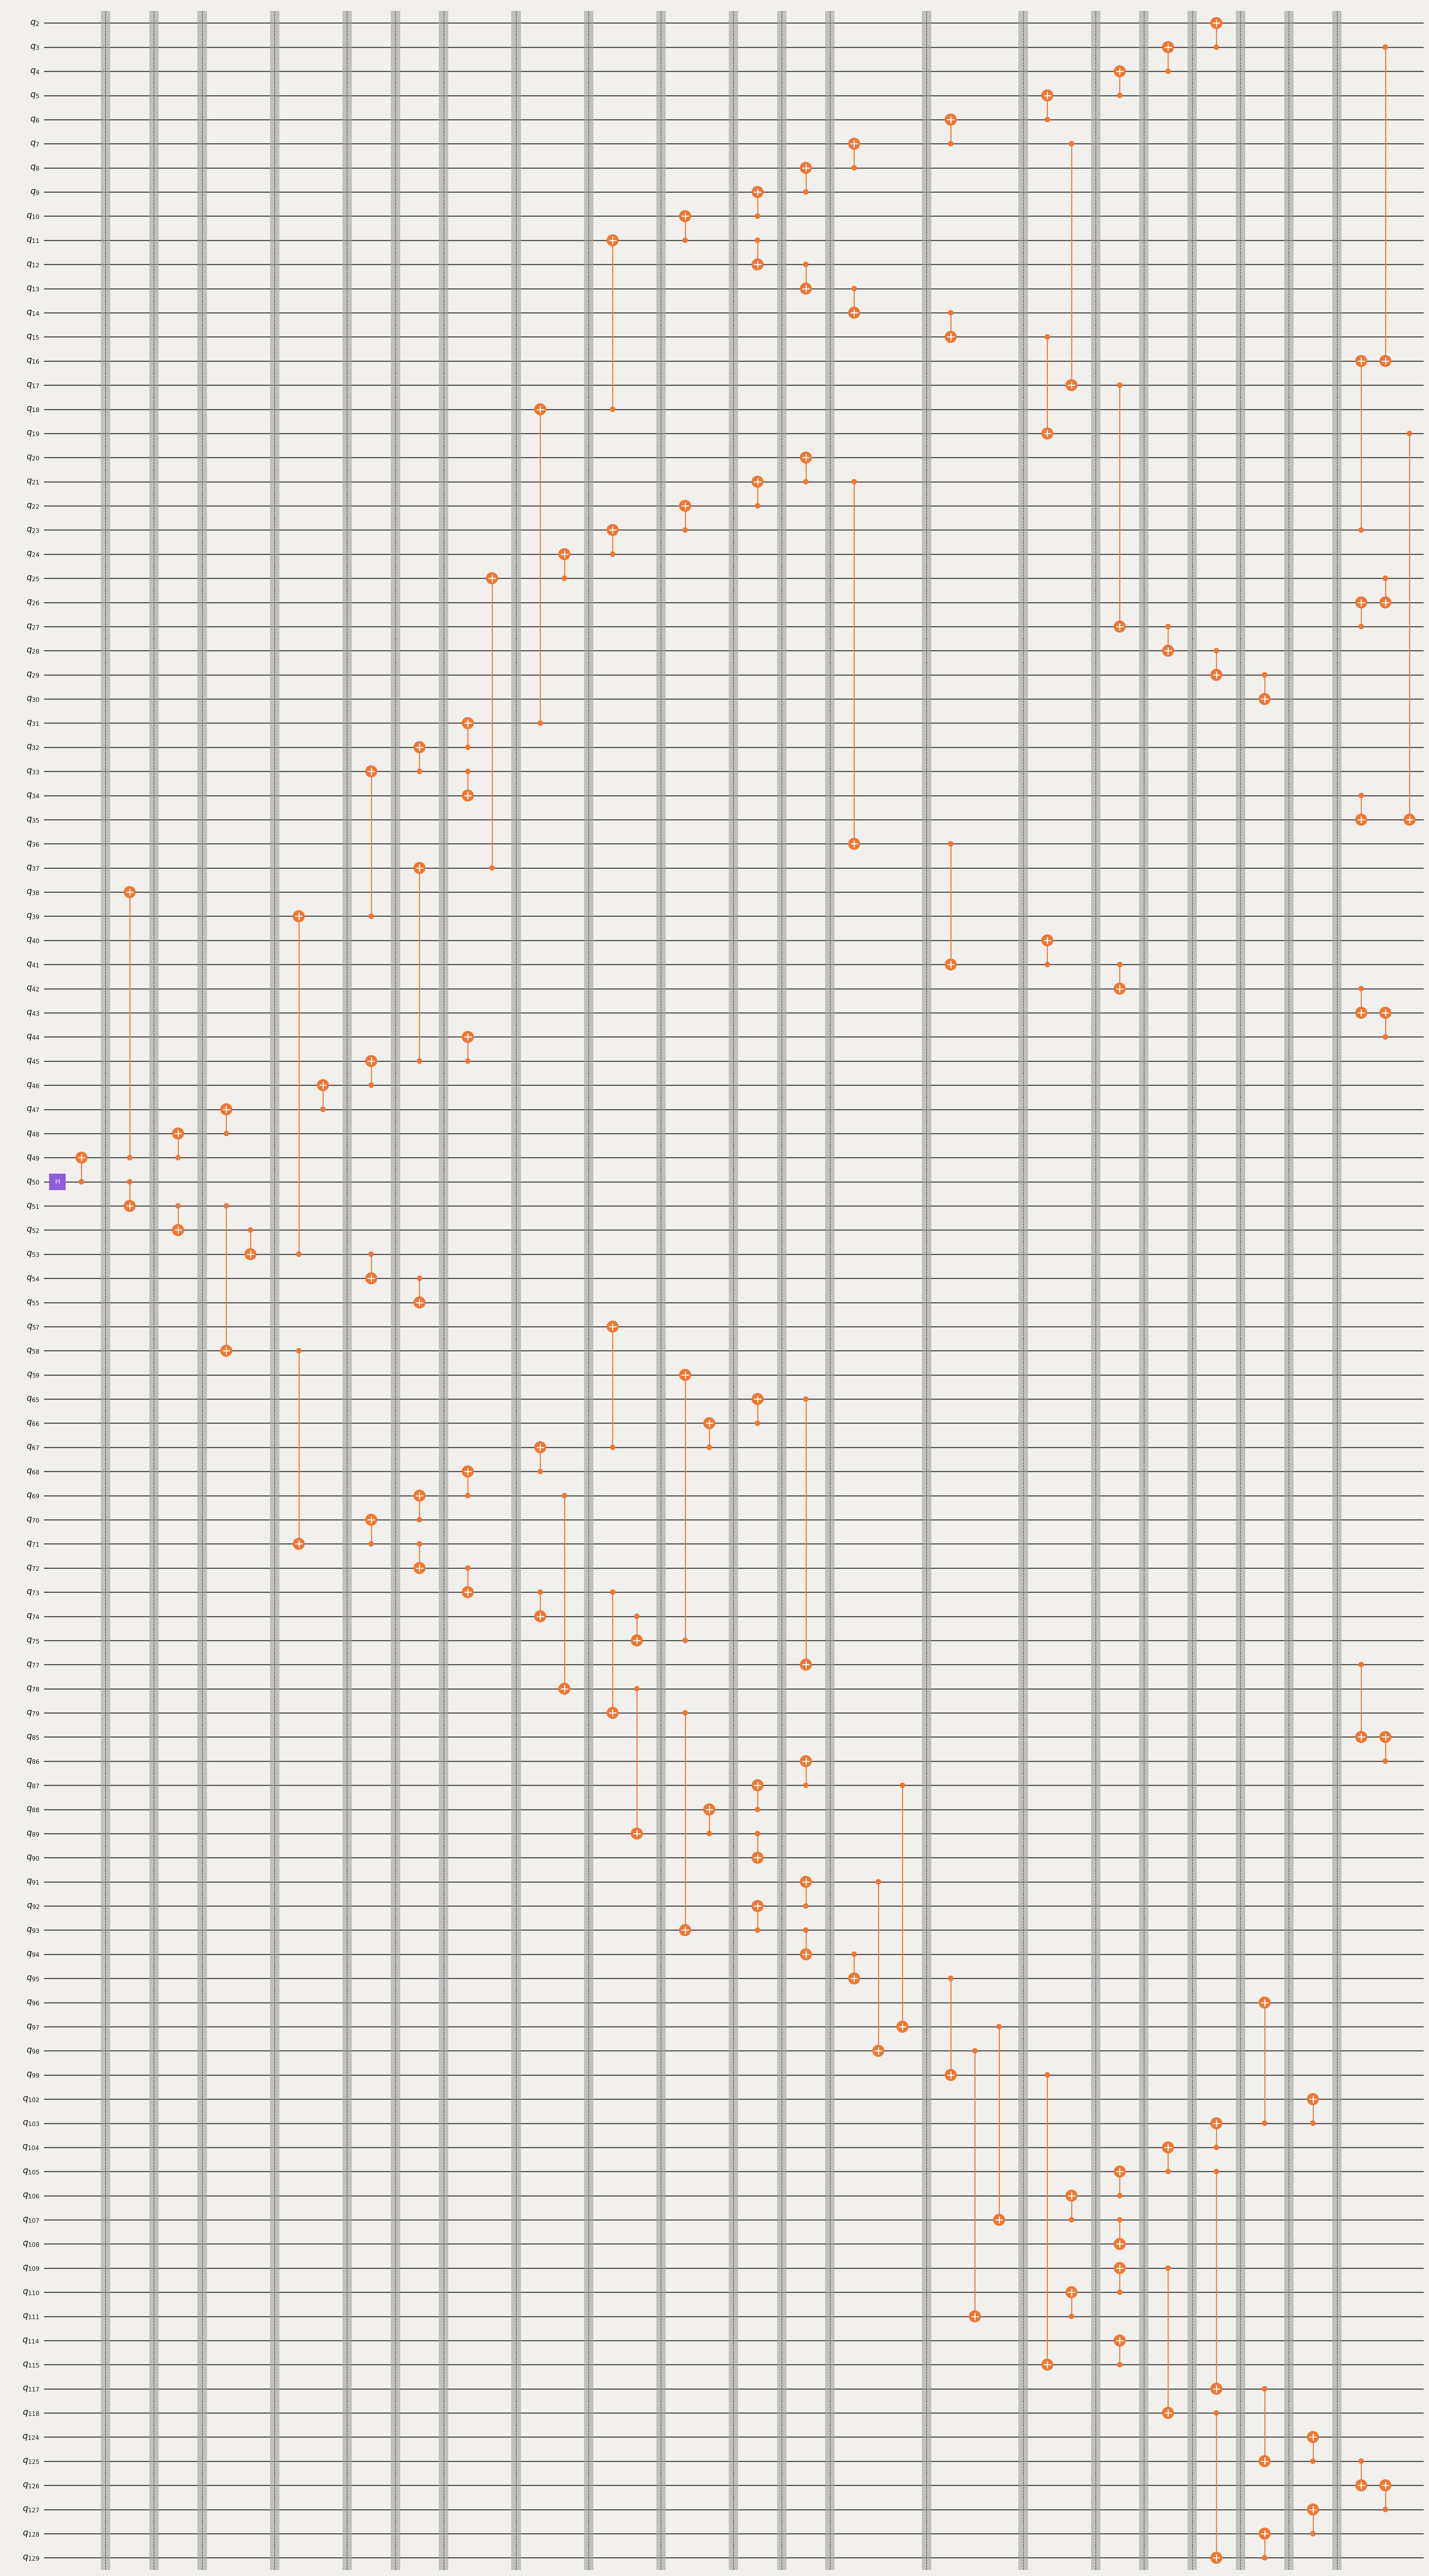

In [29]:
qc.draw("mpl", idle_wires=False, fold=-1)

We now add the measurements.

In [30]:
qc = add_measurements(qc, ghz_qubits, checks)

The scheduling pipeline below locks in timing, removes barriers, simplifies delays, and injects dynamical decoupling, all while preserving the original operation times.

In [31]:
# The scheduling consists of first inserting delays while barriers are still there
# Then removing the barriers and consolidating the delays, so that the operations do not move in time
# Lastly we replace delays with dynamical decoupling
collect_function = partial(
    collect_using_filter_function,
    filter_function=(lambda node: node.op.name == "delay"),
    split_blocks=True,
    min_block_size=2,
    split_layers=False,
    collect_from_back=False,
    max_block_width=None,
)

collapse_function = partial(
    collapse_to_operation,
    collapse_function=(
        lambda circ: Delay(sum(inst.operation.duration for inst in circ))
    ),
)


class Unschedule(AnalysisPass):
    """Removes a property from the passmanager property set so that the circuit looks unscheduled, so we can schedule it again."""

    def run(self, dag):
        del self.property_set["node_start_time"]


def build_passmanager(backend, dd_qubits=None):
    pm = generate_preset_pass_manager(
        target=backend.target,
        layout_method="trivial",
        optimization_level=2,
        routing_method="none",
    )

    pm.scheduling = PassManager(
        [
            ALAPScheduleAnalysis(target=backend.target),
            PadDelay(target=backend.target),
            RemoveBarriers(),
            Unschedule(),
            CollectAndCollapse(
                collect_function=collect_function,
                collapse_function=collapse_function,
            ),
            ALAPScheduleAnalysis(target=backend.target),
            PadDynamicalDecoupling(
                dd_sequence=[XGate(), RZGate(-np.pi), XGate(), RZGate(np.pi)],
                spacing=[1 / 4, 1 / 2, 0, 0, 1 / 4],
                target=backend.target,
                qubits=dd_qubits,
            ),
        ]
    )

    return pm

We can now use the custom pass manager to transpile the circuit for the selected backend.

In [ ]:
# Transpile the circuits for the backend
pm = build_passmanager(backend, ghz_qubits)

# Instruction set architecture (ISA) level circuit after scheduling and DD insertion
isa_circuit = pm.run(qc)

# Draw after scheduling and DD insertion
# timeline_drawer(isa_circuit, show_idle=False, time_range=(0, 1000), target=backend.target)

In [33]:
isa_circuit.draw("mpl", fold=-1, idle_wires=False)

We then submit the job using the Qiskit Runtime Sampler primitive.

In [ ]:
use_cached_results = True

# Select the sampler options
sampler = Sampler(mode=backend)
sampler.options.default_shots = SHOTS
sampler.options.dynamical_decoupling.enable = False
sampler.options.execution.rep_delay = 0.00025

if use_cached_results:
    ghz_job = shared_service.job("d493f17nmdfs73abf9qg")
else:
    # Submit the job
    print("Submitting sampler job")
    ghz_job = sampler.run([isa_circuit])

print(ghz_job.job_id())

d493f17nmdfs73abf9qg


## Step 4: Post-process and return result in desired classical format
We can now retrieve and analyze the results from the Sampler job.

In [33]:
# Retrieve the job results
job_result = ghz_job.result()

In [34]:
# Get the counts from GHZ and check qubit measurements
ghz_counts = job_result[0].data.c1.get_counts()
checks_counts = job_result[0].data.c2.get_counts()

In [35]:
# Post-process to get unflagged GHZ counts (i.e., check bits are all '0')
joined_counts = job_result[0].join_data().get_counts()
unflagged_counts = {}
for key, count in joined_counts.items():
    check_bits = key[: len(checks)]
    ghz_bits = key[len(checks) :]
    if set(check_bits) == {"0"}:
        unflagged_counts[ghz_bits] = count

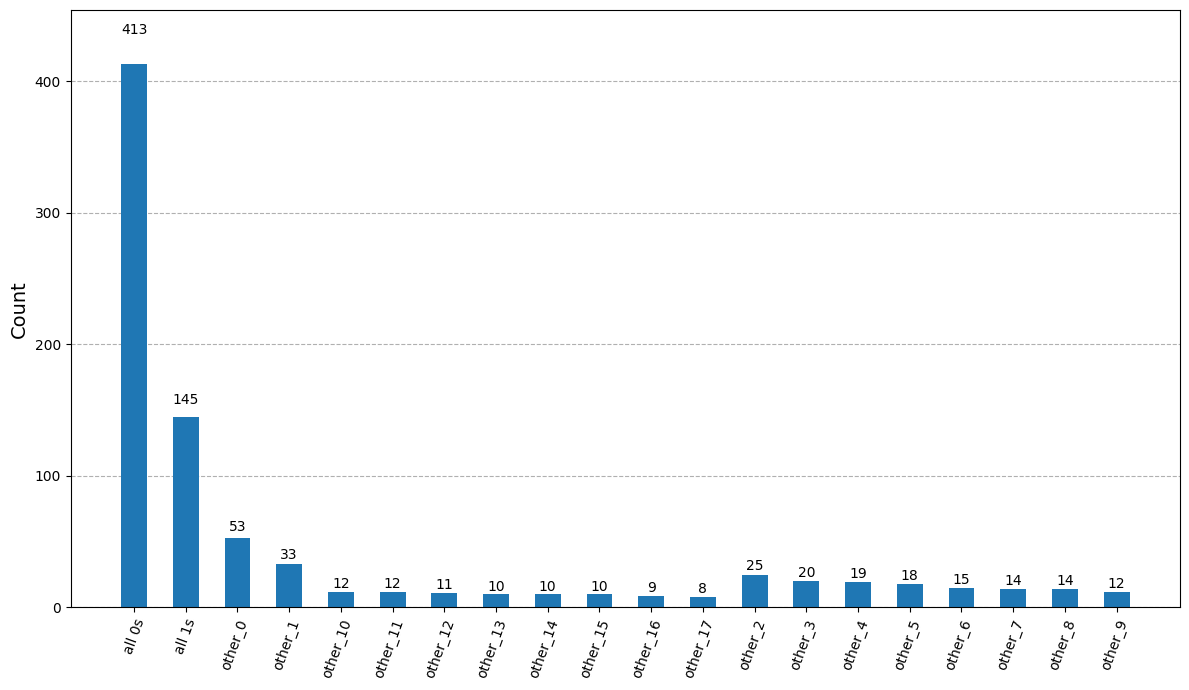

In [36]:
# Get top 20 outcomes by frequency from the unflagged counts
top_counts = dict(
    sorted(unflagged_counts.items(), key=lambda x: x[1], reverse=True)[:20]
)

# Rename keys for better visualization
top_counts_renamed = {}
i = 0
for key, count in top_counts.items():
    if set(key) == {"0"}:
        top_counts_renamed["all 0s"] = count
    elif set(key) == {"1"}:
        top_counts_renamed["all 1s"] = count
    else:
        top_counts_renamed[f"other_{i}"] = count
        i += 1

plot_histogram(top_counts_renamed, figsize=(12, 7))

In the histogram above, we plotted 20 bitstring measurements from the GHZ qubits that were not flagged by the check qubits. As expected, all-0 and all-1 bitstrings have the highest counts. Note that some erroneous bitstrings with low error weights were not captured by the error detection. The highest counts are still found in the expected bitstrings.

## Discussion

In this tutorial, we showed how to implement a low-overhead error detection technique using spacetime codes, and demonstrated its real-world application to preparing GHZ states on hardware. Refer to [[3]](https://arxiv.org/abs/2510.09520) to further explore technical details of GHZ state preparation. In addition to error detection, authors utilize readout error mitigation with M3 and TREX and perform temporary uncomputation techniques to prepare high-fidelity GHZ states.

### References
- [1] Martiel, S., & Javadi-Abhari, A. (2025). Low-overhead error detection with spacetime codes. *arXiv preprint arXiv:2504.15725.*
- [2] van den Berg, E., Bravyi, S., Gambetta, J. M., Jurcevic, P., Maslov, D., & Temme, K. (2023). Single-shot error mitigation by coherent Pauli checks. *Physical Review Research*, 5(3), 033193.
- [3] Javadi-Abhari, A., Martiel, S., Seif, A., Takita, M., & Wei, K. X. (2025). Big cats: entanglement in 120 qubits and beyond. arXiv preprint arXiv:2510.09520.